<img src="./img/cabecera.png" style="height: 200px">
<center style="color:#888">
<br/><br/><b/>Implementación CNN como alternativa a clusterización</center>


### Objetivo

* El objetivo de este worksheet es presentar el ejemplo de una Red CNN (Convolutional Neural Network/ Red Neuronal Convolucional). Esta arquitectura de redes esta muy indicada para el caso de uso de clasificación de imagenes.
* Comentar que en este ejemplo se construye una CNN, pero lo idel tal vez sería ya usar redes preentrenadas para casos generales de imagenes, pero que por capacidad de procesador ya que tal vez deberían usarse bajo GPU, no se ha implementado el ejemplo. Redes de este tipo se pueden disponer en la libreias de Keras y pueden ser:
    * Xception
    * InceptionV3
    * ResNet50
    * VGG16
    * VGG19
    * MobileNet

### Carga de librerías

In [1]:
#pip install tensorflow Se inatala la versión de tensorflow 2.0 superior que ya unifica tensorflow y keras.

In [2]:
import sys
import os
import os.path as path
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.layers import  Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras import applications
import matplotlib.pyplot as plt


### Preprocesamiento de imagenes y captura de las features

* Preparamos nuestras imagenes y parametrizamos ImageDataGenerator para realizar data augmentation parametrizando distintos filtros y rotaciones
* Obtenemos las imagenes a traves del método flow_from_directory de la clase 

In [3]:
K.clear_session()



data_entrenamiento = './technical_test_images_cnn/entrenamiento'
data_validacion = './technical_test_images_cnn/validacion'
data_test = './technical_test_images_cnn/test'

"""
Parametros
"""
epocas=20
longitud, altura = 128, 128
batch_size = 32
pasos = 1000
validation_steps = 300
filtrosConv1 = 32
filtrosConv2 = 64
tamano_filtro1 = (3, 3)
tamano_filtro2 = (2, 2)
tamano_pool = (2, 2)
clases = 3
lr = 0.0001


#Preparamos nuestras imagenes y parametrizamos para realizar data augmentation parametrizando distintos filtros y rotaciones

entrenamiento_datagen = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)


val_datagen = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)


BATCH_SIZE = 32

entrenamiento_generador = entrenamiento_datagen.flow_from_directory(data_entrenamiento,
                                               target_size=(longitud, altura),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
#                                                classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validacion_generador = val_datagen.flow_from_directory(
                                                data_validacion,
                                               target_size=(longitud, altura),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
#                                                classes=class_subset,
#                                                 subset='validation',
#                                                shuffle=True,
                                               seed=42)

print("\n")
print('Generador            : ',entrenamiento_generador.image_data_generator)
print('Directorio con datos : ',entrenamiento_generador.directory)
print('Clases               : ',entrenamiento_generador.class_indices)
print('Forma de cada imagen : ',entrenamiento_generador.image_shape)

Found 32 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


Generador            :  <keras.preprocessing.image.ImageDataGenerator object at 0x0000028D11C5D730>
Directorio con datos :  ./technical_test_images_cnn/entrenamiento
Clases               :  {'girasol': 0, 'otro': 1, 'rosa': 2}
Forma de cada imagen :  (128, 128, 3)


### Configuración de la CNN (Convolutional Neuronal Network)

* Pasamos a configurar la CNN. A nivel de resumen una CNN se compone:
    * Capa de entrada: los valores de píxeles sin procesar de una imagen representada como una matriz 3D Dimensiones  X  X , donde la profundidad corresponde al número de canales de color en la imagen.
    * Capa convolucional: Las capas calcularán la salida de los nodos que están conectados a las regiones locales de la matriz de entrada. Los productos de puntos se calculan entre un conjunto de pesos (comúnmente llamado filtro ) y los valores asociados con una región local de la entrada.
    * Capa ReLu (activación):El volumen de salida de la capa convulacional. La capa se alimenta a una función de activación por elementos, comúnmente una Unidad lineal rectificada (ReLu).
    * Capa de agrupación: Se aplica una estrategia de muestreo descendente para reducir la anchura y la altura del volumen de salida.
    * Capa completamente conectada: El volumen de salida, es decir, las 'entidades convolucionadas', se pasan a una capa de nodos totalmente conectada. Al igual que las redes neuronales convencionales, todos los nodos de esta capa están conectados a todos los nodos del volumen de funciones que se adelantan.Las probabilidades de clase se calculan y se generan en una matriz 3D.

In [4]:
modelo = Sequential()

#### Capa de entrada ####
modelo.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(longitud, altura, 3)))

#### Capas convolutacionales ####
modelo.add(Conv2D(32, (3,3), activation='relu'))
modelo.add(MaxPool2D((2,2)))  # Pooling
modelo.add(Dropout(0.2)) # Dropout

modelo.add(Conv2D(64, (3,3), padding='same', activation='relu'))
modelo.add(Conv2D(64, (3,3), activation='relu'))
modelo.add(MaxPool2D((2,2)))
modelo.add(Dropout(0.2))

modelo.add(Conv2D(128, (3,3), padding='same', activation='relu'))
modelo.add(Conv2D(128, (3,3), activation='relu'))
modelo.add(Activation('relu'))
modelo.add(MaxPool2D((2,2)))
modelo.add(Dropout(0.2))

modelo.add(Conv2D(512, (5,5), padding='same', activation='relu'))
modelo.add(Conv2D(512, (5,5), activation='relu'))
modelo.add(MaxPool2D((4,4)))
modelo.add(Dropout(0.2))

#### Capa de salida ####
modelo.add(Flatten())
modelo.add(Dense(1024, activation='relu'))
modelo.add(Dropout(0.2))
modelo.add(Dense(clases, activation='softmax'))

modelo.summary() # a handy way to inspect the architecture

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

### Entrenamiento y test

In [5]:
steps_per_epoch = entrenamiento_generador.samples // BATCH_SIZE
val_steps = validacion_generador.samples // BATCH_SIZE

# optimizer = 'rmsprop'
optimizer = RMSprop(learning_rate=lr)

modelo.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Entrenamos el modelo
history = modelo.fit(entrenamiento_generador,
                    epochs=epocas, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validacion_generador,
                    validation_steps=val_steps,
#                     callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)
#Guardamos el modelo y sus pesos para no tener que volver a entrenar cuando lo queramos ejecutar.
target_dir = './modelo/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
modelo.save('./modelo/modelo.h5')
modelo.save_weights('./modelo/pesos.h5')

In [6]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(data_test,
                                             target_size=(longitud, altura),
                                             batch_size=1)
# ,
# #                                          class_mode=None,
# #                                              classes=class_subset, 
# #                                              shuffle=False,
#                                              seed=42)

predicted_classes = modelo.predict(testgen)

class_indices = entrenamiento_generador.class_indices
print(f'Las clases generadas son : {class_indices}')
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

Found 8 images belonging to 3 classes.
Las clases generadas son : {'girasol': 0, 'otro': 1, 'rosa': 2}


In [7]:
print(f"Media del Indicador de preción Accuracy es : {np.mean(history.history['accuracy'])}")

Media del Indicador de preción Accuracy es : 0.4328125


### Prueba con imagenes

In [8]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model


longitud, altura = 128, 128
modelo = './modelo/modelo.h5'
pesos_modelo = './modelo/pesos.h5'
modelo = load_model(modelo)
modelo.load_weights(pesos_modelo)

def predict2(file):
 
  x = load_img(file, target_size=(longitud, altura))
  plt.imshow(x)
  plt.show()  
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  array = modelo.predict(x)
  print(f"Imagen :{file}")  
  print(f'Probabilidades de clase :{array}')
  result = array[0]
  answer = np.argmax(result)
  if answer == 0:
    print("Predicción es --> Girasol")
  elif answer == 1:
    print("Predicción es --> Otro")
  elif answer == 2:
    print("Predicción es --> Rosa")

  return answer

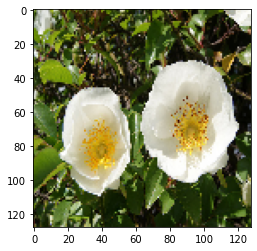

Imagen :./technical_test_images\imagen1426.jpg
Probabilidades de clase :[[1.0000000e+00 0.0000000e+00 3.0853242e-09]]
Predicción es --> Girasol


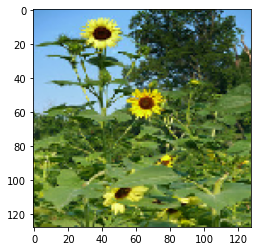

Imagen :./technical_test_images\imagen585.jpg
Probabilidades de clase :[[1.0000000e+00 0.0000000e+00 2.5557398e-10]]
Predicción es --> Girasol


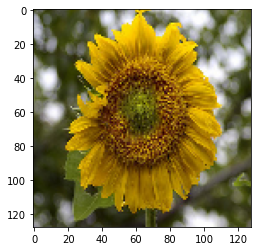

Imagen :./technical_test_images\imagen813.jpg
Probabilidades de clase :[[1. 0. 0.]]
Predicción es --> Girasol


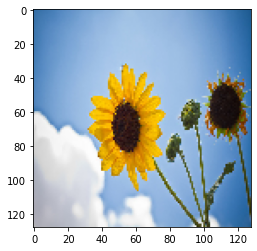

Imagen :./technical_test_images\imagen1299.jpg
Probabilidades de clase :[[1. 0. 0.]]
Predicción es --> Girasol


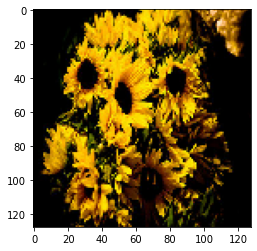

Imagen :./technical_test_images\imagen975.jpg
Probabilidades de clase :[[1. 0. 0.]]
Predicción es --> Girasol


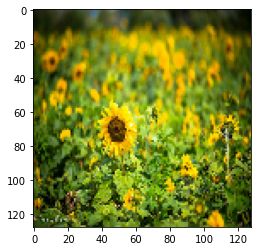

Imagen :./technical_test_images\imagen1216.jpg
Probabilidades de clase :[[1. 0. 0.]]
Predicción es --> Girasol


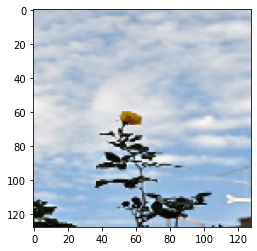

Imagen :./technical_test_images\imagen397.jpg
Probabilidades de clase :[[0. 1. 0.]]
Predicción es --> Otro


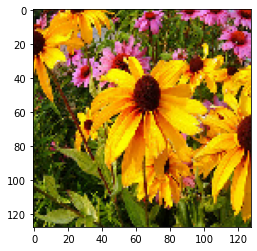

Imagen :./technical_test_images\imagen1121.jpg
Probabilidades de clase :[[1. 0. 0.]]
Predicción es --> Girasol


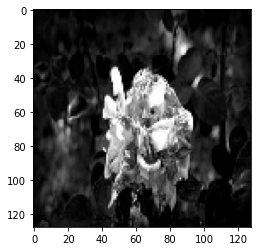

Imagen :./technical_test_images\imagen12.jpg
Probabilidades de clase :[[0. 1. 0.]]
Predicción es --> Otro


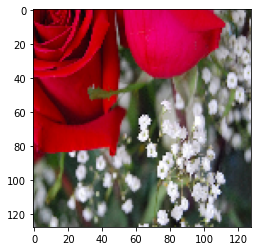

Imagen :./technical_test_images\imagen1303.jpg
Probabilidades de clase :[[1. 0. 0.]]
Predicción es --> Girasol


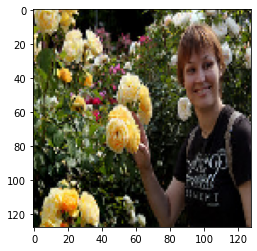

Imagen :./technical_test_images\imagen535.jpg
Probabilidades de clase :[[1.0000000e+00 0.0000000e+00 4.8473168e-17]]
Predicción es --> Girasol


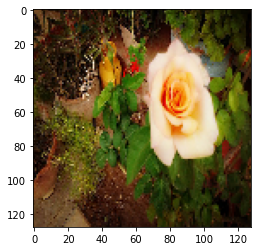

Imagen :./technical_test_images\imagen1164.jpg
Probabilidades de clase :[[1.0000000e+00 0.0000000e+00 2.2283585e-31]]
Predicción es --> Girasol


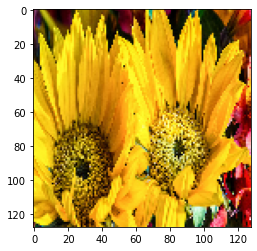

Imagen :./technical_test_images\imagen1407.jpg
Probabilidades de clase :[[1. 0. 0.]]
Predicción es --> Girasol


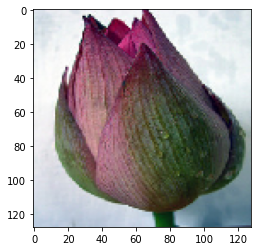

Imagen :./technical_test_images\imagen214.jpg
Probabilidades de clase :[[0.000000e+00 1.000000e+00 4.075331e-32]]
Predicción es --> Otro


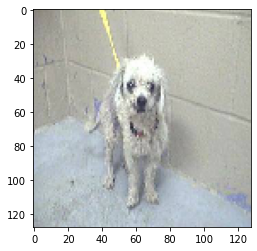

Imagen :./technical_test_images\imagen11.jpg
Probabilidades de clase :[[0. 1. 0.]]
Predicción es --> Otro


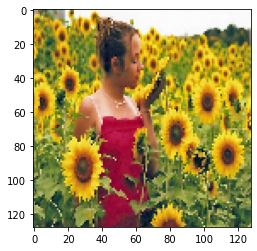

Imagen :./technical_test_images\imagen1470.jpg
Probabilidades de clase :[[1.0000000e+00 0.0000000e+00 2.9327638e-33]]
Predicción es --> Girasol


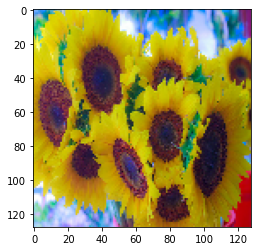

Imagen :./technical_test_images\imagen1464.jpg
Probabilidades de clase :[[1. 0. 0.]]
Predicción es --> Girasol


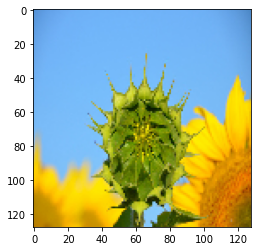

Imagen :./technical_test_images\imagen1217.jpg
Probabilidades de clase :[[9.999926e-01 0.000000e+00 7.406645e-06]]
Predicción es --> Girasol


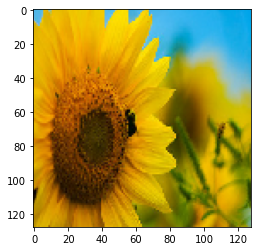

Imagen :./technical_test_images\imagen447.jpg
Probabilidades de clase :[[1. 0. 0.]]
Predicción es --> Girasol


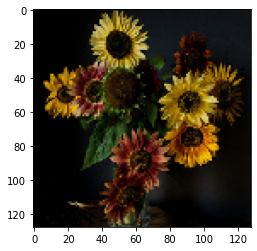

Imagen :./technical_test_images\imagen438.jpg
Probabilidades de clase :[[1.0000000e+00 0.0000000e+00 1.5333165e-15]]
Predicción es --> Girasol


In [9]:
PATH='./technical_test_images\\'
indices_imagenes=np.random.randint(1,1576,20)
for i in indices_imagenes:# range(20,40):
    nombre_imagen=PATH+'imagen'+str(i)+'.jpg'
    if not (path.exists(nombre_imagen)):
        nombre_imagen=PATH+'imagen'+str(i)+'.jpeg'
        if not (path.exists(nombre_imagen)):
            continue
        else:        
            predict2(nombre_imagen)
    else:
        predict2(nombre_imagen)

### Conslusión

* Parece que los resultados son buenos, obtenemos un accuracy medio de más de 0,75 que seguramane se podría mejorar con algún proceso de ajuste, usar una CNN, sería una buena alternativa bien partiendo con una etiquetación algo más amplia, o con una primera clasificación e identificando las mejores clasificadas.